### Problem Statment

Build a model to predict the value of the question in the TV game show “Jeopardy!”. 

Data can be downloaded from this link: https://www.kaggle.com/tunguz/200000-jeopardy-questions 

##### Data description:

'category' : the question category, e.g. "HISTORY" 

'value' : $ value of the question as string, e.g. "$200" (Note - "None" for Final Jeopardy! and Tiebreaker questions)

'question' : text of question (Note: This sometimes contains hyperlinks and other things messy text such as when there's a picture or video question)

‘answer' : text of answer 

‘round' : one of "Jeopardy!", "Double Jeopardy!", "Final Jeopardy!" or "Tiebreaker" (Note: Tiebreaker questions do happen but they're very rare (like once every 20 years)

'show_number' : string of show number, e.g '4680' 

'air_date' : the show air date in format YYYY-MM-DD 

# Exploratory data analysis

#### Import the libraries

In [386]:
# for numerical computing
import numpy as np

# for dataframes
import pandas as pd

# for easier visualization
import seaborn as sns

# for visualization and to display plots
from matplotlib import pyplot as plt
%matplotlib inline

# import color maps
from matplotlib.colors import ListedColormap

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

from math import sqrt

# to split train and test set
from sklearn.model_selection import train_test_split

# Evaluation Metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as rs
from sklearn.metrics import mean_absolute_error as mae

In [334]:
np.set_printoptions(precision=2, suppress=True) #for printing floating point numbers upto  precision 2

Load data from CSV

In [335]:
df = pd.read_csv('/mnt/data/projects/Real-Estate-master/JEOPARDY_CSV.csv')

Display the dimensions of the dataset.

In [336]:
df.shape

(216930, 7)

Columns of the dataset

In [337]:
df.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [338]:
# Cleaning up column names
newcols=[]
for c in df.columns:
    newcols.append(c.strip())
df.columns=newcols
df.columns
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


Some feaures are numeric and some are categorical<br>

In [339]:
df.dtypes[df.dtypes=='object']

Air Date    object
Round       object
Category    object
Value       object
Question    object
Answer      object
dtype: object

## Distributions of categorical features
Display summary statistics for categorical features.

In [340]:
df.describe(include=['object'])

,Air Date,Round,Category,Value,Question,Answer
count,216930,216930,216930,216930,216930,216928
unique,3640,4,27995,150,216124,88268
top,2007-11-13,Jeopardy!,BEFORE & AFTER,$400,[audio clue],China
freq,62,107384,547,42244,17,216


### Normalizing Question and Category column

In [341]:
import re
def normalize(s):
    s = str(s)
    s = s.lower()
    s = re.sub(" +"," ",s)
    s = re.sub("[^A-Za-z0-9\s]","",s)
    
    
    return s

df["Question"] = df["Question"].apply(normalize)
df["Question"].head(10)

0    for the last 8 years of his life galileo was u...
1    no 2 1912 olympian football star at carlisle i...
2    the city of yuma in this state has a record av...
3    in 1963 live on the art linkletter show this c...
4    signer of the dec of indep framer of the const...
5    in the title of an aesop fable this insect sha...
6    built in 312 bc to link rome  the south of ita...
7    no 8 30 steals for the birmingham barons 2306 ...
8    in the winter of 197172 a record 1122 inches o...
9    this housewares store was named for the packag...
Name: Question, dtype: object

In [342]:
df["Category"] = df["Category"].apply(normalize)
df["Category"].head(10)

0                          history
1    espns top 10 alltime athletes
2         everybody talks about it
3                 the company line
4               epitaphs  tributes
5                    3letter words
6                          history
7    espns top 10 alltime athletes
8         everybody talks about it
9                 the company line
Name: Category, dtype: object

### Normalizing Value and Air Date columns

In [343]:
def norm_value(s):
    s = re.sub("[^0-9\s]","",s)
    try:
        s = int(s)
    except Exception:
        s = 0
    return s

df["Value"] = df["Value"].apply(norm_value)
df["Value"].head()

0    200
1    200
2    200
3    200
4    200
Name: Value, dtype: int64

In [344]:
df["Air Date"] = df["Air Date"].apply(pd.to_datetime)
df.dtypes

Show Number             int64
Air Date       datetime64[ns]
Round                  object
Category               object
Value                   int64
Question               object
Answer                 object
dtype: object

In [345]:
df["Air Year"]=df["Air Date"].dt.year
df = df.drop(["Answer","Air Date"],axis=1)
df.head()

,Show Number,Round,Category,Value,Question,Air Year
0,4680,Jeopardy!,history,200,for the last 8 years of his life galileo was u...,2004
1,4680,Jeopardy!,espns top 10 alltime athletes,200,no 2 1912 olympian football star at carlisle i...,2004
2,4680,Jeopardy!,everybody talks about it,200,the city of yuma in this state has a record av...,2004
3,4680,Jeopardy!,the company line,200,in 1963 live on the art linkletter show this c...,2004
4,4680,Jeopardy!,epitaphs tributes,200,signer of the dec of indep framer of the const...,2004


### Handling Sparse Classes

Jeopardy!           107384
Double Jeopardy!    105912
Final Jeopardy!       3631
Tiebreaker               3
Name: Round, dtype: int64

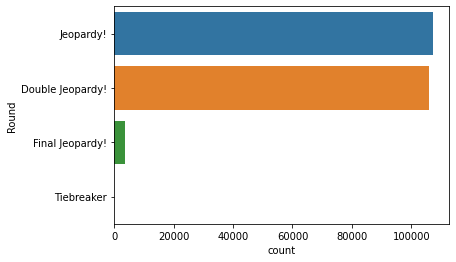

In [348]:
# Bar plot for Rounds
sns.countplot(y='Round', data=df)
df.groupby('Round').size()
rows = df.shape[0]
res = df['Round'].value_counts()
res

Final Jeopardy is merged with Double Jeopardy and Tiebreaker is removed

In [349]:
df.Round.replace('Final Jeopardy!', 'Double Jeopardy!', inplace=True)
df = df[df.Round != 'Tiebreaker']


<AxesSubplot:xlabel='count', ylabel='Round'>

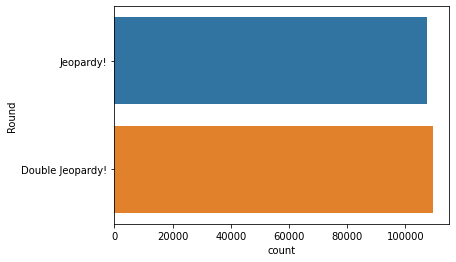

In [350]:
# Bar plot for Rounds
sns.countplot(y='Round', data=df)

In [351]:
df.describe(include=['object'])

,Round,Category,Question
count,216927,216927,216927
unique,2,27129,215902
top,Double Jeopardy!,before after,audio clue
freq,109543,557,22


### Encode dummy variables (One Hot Encoding)

In [361]:
# Create a new dataframe with dummy variables for for our categorical features.
df = pd.get_dummies(df, columns=['Round'])

In [362]:
df.head()

,Show Number,Category,Value,Question,Air Year,Round_Double Jeopardy!,Round_Jeopardy!
0,4680,history,200,for the last 8 years of his life galileo was u...,2004,0,1
1,4680,espns top 10 alltime athletes,200,no 2 1912 olympian football star at carlisle i...,2004,0,1
2,4680,everybody talks about it,200,the city of yuma in this state has a record av...,2004,0,1
3,4680,the company line,200,in 1963 live on the art linkletter show this c...,2004,0,1
4,4680,epitaphs tributes,200,signer of the dec of indep framer of the const...,2004,0,1


### Embeding the texts using doc2vec

#### Embeding category text

In [363]:
category_sentences = df['Category'].tolist()

In [364]:
import nltk

nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np


# Tokenization of each document
tokenized_sent = []
for s in category_sentences:
    tokenized_sent.append(word_tokenize(s.lower()))
print(tokenized_sent)


def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))


# import
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]
print(tagged_data)

## Train doc2vec model
model = Doc2Vec(tagged_data, vector_size=10, window=2, min_count=1, epochs=100)


[nltk_data] Downloading package punkt to /home/shah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [354]:
test_doc_vector = []
for s in category_sentences:
    test_doc = word_tokenize(s.lower())
    test_doc_vector.append(model.infer_vector(test_doc))

In [241]:
test_doc_vector[200000]
len(test_doc_vector)

216927

In [356]:
c = list(item for item in test_doc_vector)
dc = pd.DataFrame.from_records(a)
dc = de.set_axis(['c0','c1', 'c2', 'c3','c4', 'c5', 'c6','c7', 'c8', 'c9' ], axis=1)
dc

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,-0.211373,0.040307,0.702419,0.372439,0.473840,-0.231430,0.555832,-0.014538,-0.481342,0.177285
1,-0.123801,-0.294776,-0.265423,0.387594,0.305734,-0.098859,0.540038,0.671069,-1.845611,-0.144182
2,0.517179,0.545997,-0.361311,-0.876522,0.175933,0.625712,-0.173544,0.207144,-0.258247,0.482443
3,-0.747820,-0.157023,-0.673968,-0.826141,0.766681,-0.311914,-0.803004,0.182583,-0.223990,-1.165086
4,0.257340,-0.622322,0.285451,0.154185,-0.679377,-0.531168,0.019580,0.103765,-0.078923,0.500178
...,...,...,...,...,...,...,...,...,...,...
216922,-0.000890,-0.738955,0.914796,0.053549,-0.514787,-0.683790,-0.681485,-0.770148,-0.510509,-0.163145
216923,-0.785341,-0.713325,1.478143,-0.160612,0.227639,-0.826561,1.239420,-0.637160,-0.574025,1.038723
216924,-0.350886,-1.000004,0.050005,-0.080470,0.810665,-0.689224,-0.047331,0.859174,-0.454078,0.873467
216925,0.375733,-0.007614,0.618799,0.260444,-0.324551,-0.403456,0.433590,0.762392,-0.735673,0.010719


In [357]:
result = pd.concat([df, dc], axis=1)

In [358]:
result.head()

,Show Number,Round,Category,Value,Question,Air Year,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,4680.0,Jeopardy!,history,200.0,for the last 8 years of his life galileo was u...,2004.0,-0.211373,0.040307,0.702419,0.372439,0.473840,-0.231430,0.555832,-0.014538,-0.481342,0.177285
1,4680.0,Jeopardy!,espns top 10 alltime athletes,200.0,no 2 1912 olympian football star at carlisle i...,2004.0,-0.123801,-0.294776,-0.265423,0.387594,0.305734,-0.098859,0.540038,0.671069,-1.845611,-0.144182
2,4680.0,Jeopardy!,everybody talks about it,200.0,the city of yuma in this state has a record av...,2004.0,0.517179,0.545997,-0.361311,-0.876522,0.175933,0.625712,-0.173544,0.207144,-0.258247,0.482443
3,4680.0,Jeopardy!,the company line,200.0,in 1963 live on the art linkletter show this c...,2004.0,-0.747820,-0.157023,-0.673968,-0.826141,0.766681,-0.311914,-0.803004,0.182583,-0.223990,-1.165086
4,4680.0,Jeopardy!,epitaphs tributes,200.0,signer of the dec of indep framer of the const...,2004.0,0.257340,-0.622322,0.285451,0.154185,-0.679377,-0.531168,0.019580,0.103765,-0.078923,0.500178


#### Embeding question text

In [359]:
question_sentences = df['Question'].tolist()

In [360]:
# Tokenization of each document
tokenized_sent = []
for s in question_sentences:
    tokenized_sent.append(word_tokenize(s.lower()))
print(tokenized_sent)


def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))


# import
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]
print(tagged_data)

## Train doc2vec model
model = Doc2Vec(tagged_data, vector_size=10, window=2, min_count=1, epochs=100)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [365]:
test_doc_vector = []
for q in question_sentences:
    test_doc = word_tokenize(q.lower())
    test_doc_vector.append(model.infer_vector(test_doc))

In [ ]:
test_doc_vector

In [367]:
b = list(item for item in test_doc_vector)
dq = pd.DataFrame.from_records(a)
dq = de.set_axis(['q0','q1', 'q2', 'q3','q4', 'q5', 'q6','q7', 'q8', 'q9' ], axis=1)
dq

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,-0.211373,0.040307,0.702419,0.372439,0.473840,-0.231430,0.555832,-0.014538,-0.481342,0.177285
1,-0.123801,-0.294776,-0.265423,0.387594,0.305734,-0.098859,0.540038,0.671069,-1.845611,-0.144182
2,0.517179,0.545997,-0.361311,-0.876522,0.175933,0.625712,-0.173544,0.207144,-0.258247,0.482443
3,-0.747820,-0.157023,-0.673968,-0.826141,0.766681,-0.311914,-0.803004,0.182583,-0.223990,-1.165086
4,0.257340,-0.622322,0.285451,0.154185,-0.679377,-0.531168,0.019580,0.103765,-0.078923,0.500178
...,...,...,...,...,...,...,...,...,...,...
216922,-0.000890,-0.738955,0.914796,0.053549,-0.514787,-0.683790,-0.681485,-0.770148,-0.510509,-0.163145
216923,-0.785341,-0.713325,1.478143,-0.160612,0.227639,-0.826561,1.239420,-0.637160,-0.574025,1.038723
216924,-0.350886,-1.000004,0.050005,-0.080470,0.810665,-0.689224,-0.047331,0.859174,-0.454078,0.873467
216925,0.375733,-0.007614,0.618799,0.260444,-0.324551,-0.403456,0.433590,0.762392,-0.735673,0.010719


In [368]:
result1 = pd.concat([result, dq], axis=1)

In [369]:

df = result1.drop(["Category","Question"],axis=1)
df.head()

,Show Number,Round,Value,Air Year,c0,c1,c2,c3,c4,c5,...,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,4680.0,Jeopardy!,200.0,2004.0,-0.211373,0.040307,0.702419,0.372439,0.473840,-0.231430,...,-0.211373,0.040307,0.702419,0.372439,0.473840,-0.231430,0.555832,-0.014538,-0.481342,0.177285
1,4680.0,Jeopardy!,200.0,2004.0,-0.123801,-0.294776,-0.265423,0.387594,0.305734,-0.098859,...,-0.123801,-0.294776,-0.265423,0.387594,0.305734,-0.098859,0.540038,0.671069,-1.845611,-0.144182
2,4680.0,Jeopardy!,200.0,2004.0,0.517179,0.545997,-0.361311,-0.876522,0.175933,0.625712,...,0.517179,0.545997,-0.361311,-0.876522,0.175933,0.625712,-0.173544,0.207144,-0.258247,0.482443
3,4680.0,Jeopardy!,200.0,2004.0,-0.747820,-0.157023,-0.673968,-0.826141,0.766681,-0.311914,...,-0.747820,-0.157023,-0.673968,-0.826141,0.766681,-0.311914,-0.803004,0.182583,-0.223990,-1.165086
4,4680.0,Jeopardy!,200.0,2004.0,0.257340,-0.622322,0.285451,0.154185,-0.679377,-0.531168,...,0.257340,-0.622322,0.285451,0.154185,-0.679377,-0.531168,0.019580,0.103765,-0.078923,0.500178


In [370]:

print(df.shape)

(216930, 24)


### Train and Test Splits

In [371]:

# Create separate object for target variable
y = df.Value
# Create separate object for input features
X = df.drop('Value', axis=1)

In [372]:
# Split X and y into train and test sets: 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [373]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(173544, 23) (43386, 23) (173544,) (43386,)


### Data standardization

### Data standardization
* In Data Standardization we perform zero mean centring and unit scaling; i.e. we make the mean of all the features as zero and the standard deviation as 1.
* Thus we use **mean** and **standard deviation** of each feature.
* It is very important to save the **mean** and **standard deviation** for each of the feature from the **training set**, because we use the same mean and standard deviation in the test set.

In [374]:
train_mean = X_train.mean()
train_std = X_train.std()

In [375]:
train_mean = X_train.mean()
train_std = X_train.std()

In [384]:
## Standardize the train data set
X_train = (X_train - train_mean) / train_std
X_train.fillna(value=X_train.mean(), inplace=True)

In [385]:
## Check for mean and std dev.
X_train.describe()

,Air Year,Round,Show Number,c0,c1,c2,c3,c4,c5,c6,...,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9
count,173544.000000,0.0,1.735440e+05,173544.000000,173544.000000,173544.000000,173544.000000,173544.000000,173544.000000,173544.000000,...,173544.000000,173544.000000,173544.000000,173544.000000,173544.000000,173544.000000,173544.000000,173544.000000,173544.000000,173544.000000
mean,-394.420317,NaN,-3.081591e+00,-1.796014,0.957552,-4.852122,1.842030,-2.360328,1.287730,-3.439355,...,-1.796014,0.957552,-4.852122,1.842030,-2.360328,1.287730,-3.439355,-1.585744,10.006613,1.748398
std,0.004505,NaN,3.768004e-10,7.896249,11.437337,7.420504,11.936653,6.731260,5.881749,11.366700,...,7.896249,11.437337,7.420504,11.936653,6.731260,5.881749,11.366700,8.650819,11.790420,6.360162
min,-394.434219,NaN,-3.081591e+00,-45.667822,-75.028747,-50.400387,-82.879894,-49.088788,-38.889541,-85.283844,...,-45.667822,-75.028747,-50.400387,-82.879894,-49.088788,-38.889541,-85.283844,-65.442683,-68.639946,-39.349110
25%,-394.423057,NaN,-3.081591e+00,-6.064124,-5.655789,-8.901759,-4.537730,-5.760439,-1.824228,-9.582676,...,-6.064124,-5.655789,-8.901759,-4.537730,-5.760439,-1.824228,-9.582676,-5.795888,3.236735,-1.407217
50%,-394.419336,NaN,-3.081591e+00,-1.399431,0.719784,-5.503529,1.707510,-2.714744,1.547288,-3.120221,...,-1.399431,0.719784,-5.503529,1.707510,-2.714744,1.547288,-3.120221,-1.896313,10.256123,1.722474
75%,-394.416360,NaN,-3.081591e+00,2.622006,6.953518,-0.903095,8.357992,1.091329,4.346286,3.687136,...,2.622006,6.953518,-0.903095,8.357992,1.091329,4.346286,3.687136,3.047544,16.426581,5.079030
max,-394.413383,NaN,-3.081591e+00,49.584213,73.387272,57.083265,81.898468,47.121164,46.885825,59.842319,...,49.584213,73.387272,57.083265,81.898468,47.121164,46.885825,59.842319,58.154626,99.563850,46.439809


In [378]:
## Note: We use train_mean and train_std_dev to standardize test data set
X_test = (X_test - train_mean) / train_std
X_test.fillna(value=X_test.mean(), inplace=True)

In [379]:
## Check for mean and std dev. - not exactly 0 and 1
X_test.describe()

,Air Year,Show Number,c0,c1,c2,c3,c4,c5,c6,c7,...,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9
count,43385.000000,43385.000000,43385.000000,43385.000000,43385.000000,43385.000000,43385.000000,43385.000000,43385.000000,43385.000000,...,43385.000000,43385.000000,43385.000000,43385.000000,43385.000000,43385.000000,43385.000000,43385.000000,43385.000000,43385.000000
mean,0.002666,0.003019,-0.002174,-0.007341,-0.008736,-0.001528,-0.001998,-0.005895,0.003864,-0.002412,...,-0.002174,-0.007341,-0.008736,-0.001528,-0.001998,-0.005895,0.003864,-0.002412,-0.004895,0.008514
std,1.006474,1.006468,0.991722,1.008243,1.010611,0.996634,0.998606,1.004422,1.003116,1.007646,...,0.991722,1.008243,1.010611,0.996634,0.998606,1.004422,1.003116,1.007646,0.996664,1.007753
min,-3.085658,-3.078643,-5.704536,-5.731949,-6.097453,-7.075157,-6.721990,-6.949443,-6.955457,-6.973117,...,-5.704536,-5.731949,-6.097453,-7.075157,-6.721990,-6.949443,-6.955457,-6.973117,-6.286665,-6.493547
25%,-0.608226,-0.661899,-0.538512,-0.591292,-0.550646,-0.531263,-0.506863,-0.543970,-0.538514,-0.486652,...,-0.538512,-0.591292,-0.550646,-0.531263,-0.506863,-0.543970,-0.538514,-0.486652,-0.580809,-0.486807
50%,0.217584,0.171610,0.052087,-0.024385,-0.093748,-0.011408,-0.059757,0.037960,0.038680,-0.042359,...,0.052087,-0.024385,-0.093748,-0.011408,-0.059757,0.037960,0.038680,-0.042359,0.020218,0.000520
75%,0.878233,0.821661,0.556186,0.527687,0.521558,0.544862,0.511353,0.512710,0.633338,0.523598,...,0.556186,0.527687,0.521558,0.544862,0.511353,0.512710,0.633338,0.523598,0.538038,0.534395
max,1.538881,1.470989,6.566831,6.126221,8.448518,5.524981,7.517009,7.070294,5.190149,6.945395,...,6.566831,6.126221,8.448518,5.524981,7.517009,7.070294,5.190149,6.945395,7.320705,6.859051


### Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

In [381]:
## Predict Train results
y_train_pred = model.predict(X_train)

AttributeError: 'Doc2Vec' object has no attribute 'predict'

In [327]:
## Predict Test results
y_pred = regression_model.predict(X_test)

array([1188.4 , 1206.95, 1168.67, ...,  502.86,  502.28,  663.85])

In [330]:
print("Train Results for Ridge Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", rs(y_train.values, y_train_pred))
print("Mean Absolute Error: ", mae(y_train.values, y_train_pred))

Train Results for Ridge Regression:
*******************************
Root mean squared error:  561.3254135338169
R-squared:  0.23406101147581315
Mean Absolute Error:  366.5124189673742


In [331]:
print("Test Results for Ridge Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(y_test, y_pred)))
print("R-squared: ", rs(y_test, y_pred))
print("Mean Absolute Error: ", mae(y_test, y_pred))

Test Results for Ridge Regression:
*******************************
Root mean squared error:  551.9544601677698
R-squared:  0.24088603117245333
Mean Absolute Error:  368.07358556456785
